In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Hyperparameters
T = 1000  # Number of timesteps
batch_size = 64
learning_rate = 1e-3
epochs = 10

Using device: cuda
Epoch [1/10], Batch [0/938], Loss: 1.1474
Epoch [1/10], Batch [100/938], Loss: 0.8278
Epoch [1/10], Batch [200/938], Loss: 0.1951
Epoch [1/10], Batch [300/938], Loss: 0.1066
Epoch [1/10], Batch [400/938], Loss: 0.1050
Epoch [1/10], Batch [500/938], Loss: 0.0874
Epoch [1/10], Batch [600/938], Loss: 0.0903
Epoch [1/10], Batch [700/938], Loss: 0.0784
Epoch [1/10], Batch [800/938], Loss: 0.0780
Epoch [1/10], Batch [900/938], Loss: 0.0736
Epoch [1/10], Average Loss: 0.2067
Epoch [2/10], Batch [0/938], Loss: 0.0689
Epoch [2/10], Batch [100/938], Loss: 0.0511
Epoch [2/10], Batch [200/938], Loss: 0.0605
Epoch [2/10], Batch [300/938], Loss: 0.0585
Epoch [2/10], Batch [400/938], Loss: 0.0514
Epoch [2/10], Batch [500/938], Loss: 0.0479
Epoch [2/10], Batch [600/938], Loss: 0.0699
Epoch [2/10], Batch [700/938], Loss: 0.0492
Epoch [2/10], Batch [800/938], Loss: 0.0512
Epoch [2/10], Batch [900/938], Loss: 0.0602
Epoch [2/10], Average Loss: 0.0629
Epoch [3/10], Batch [0/938], Loss: 

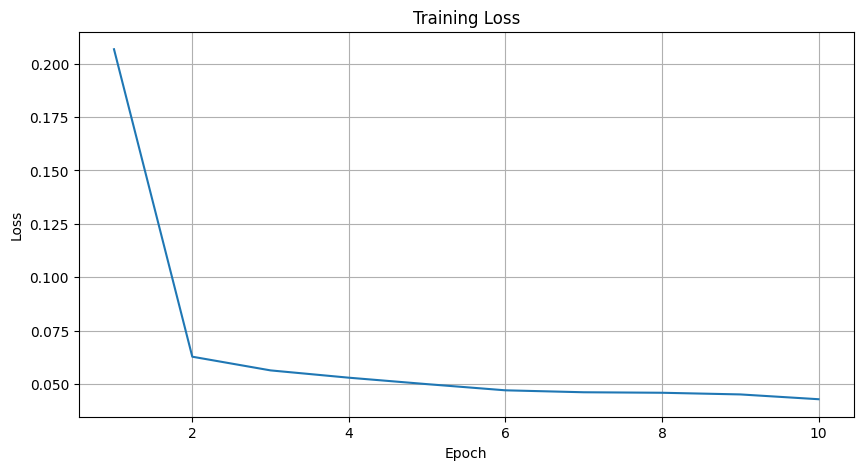

Generating samples...
Starting sampling process...
Sampling step 900
Sampling step 800
Sampling step 700
Sampling step 600
Sampling step 500
Sampling step 400
Sampling step 300
Sampling step 200
Sampling step 100
Sampling step 0


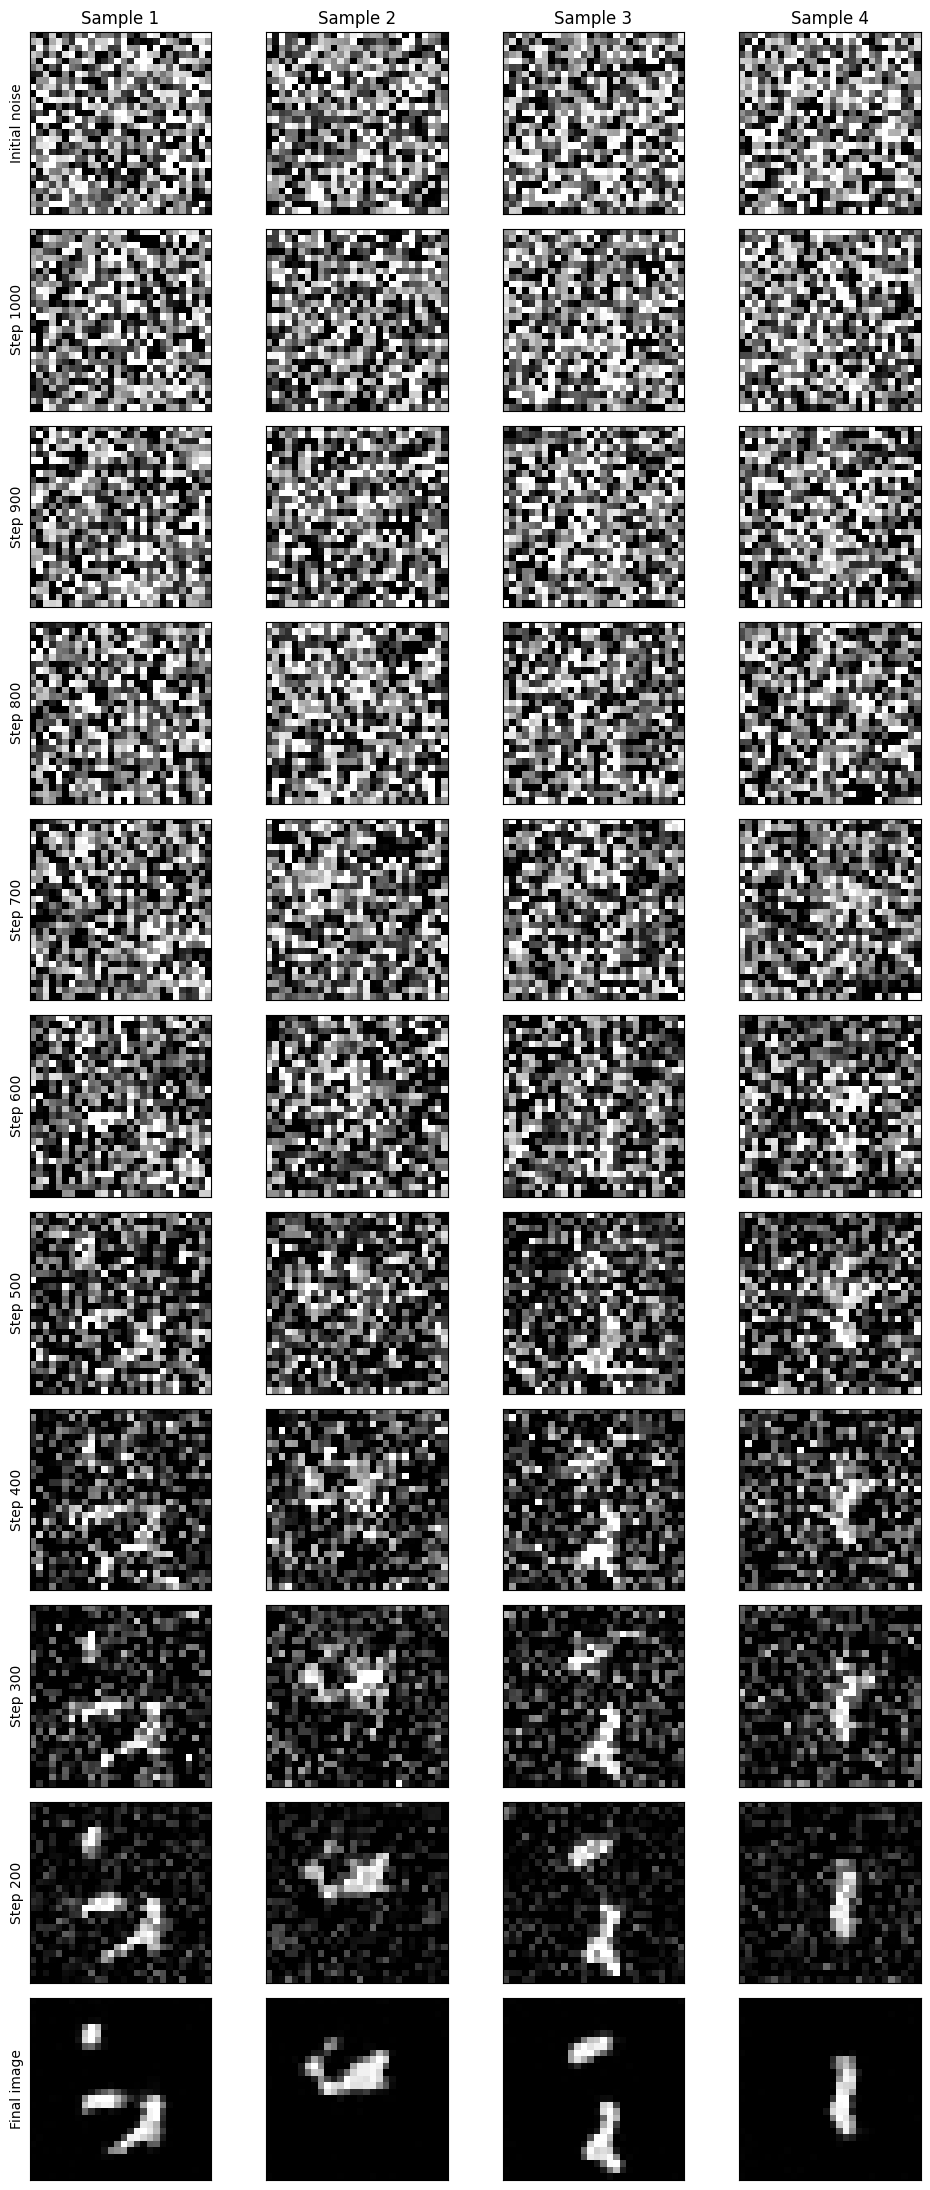

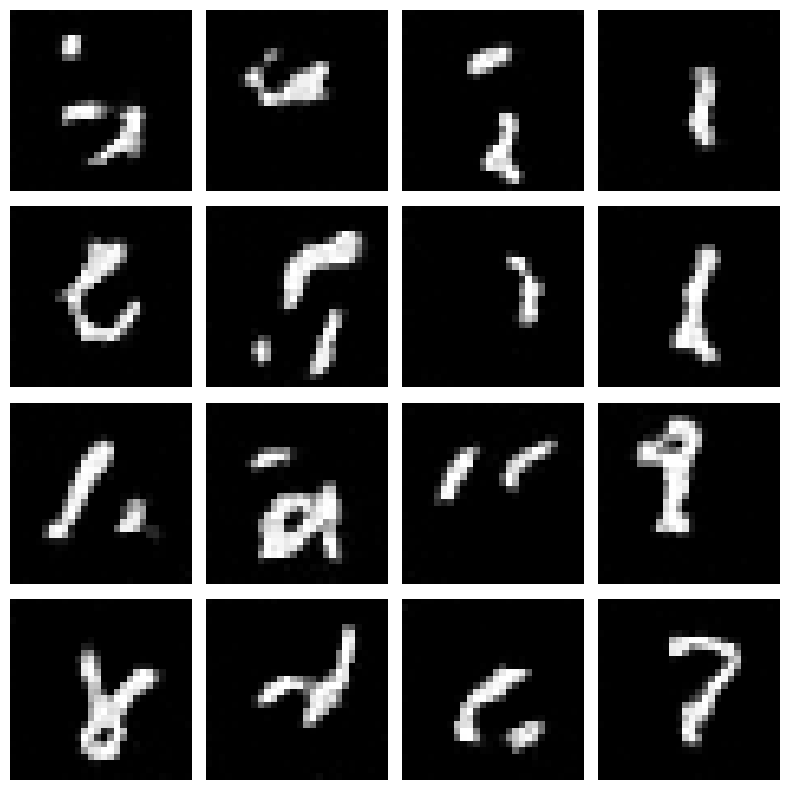

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the noise schedule (Linear beta schedule from 1e-4 to 0.02)
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0]).to(device), alphas_cumprod[:-1]])
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# Calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# Calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    """Extract coefficients from a based on t and reshape to make it broadcastable"""
    batch_size = t.shape[0]
    # Make sure both tensors are on the same device
    t = t.to(a.device)

    out = a.gather(-1, t.long())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def q_sample(x_start, t, noise=None):
    """Forward diffusion process (adding noise)"""
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise, noise

# Simpler U-Net model for denoising without skip connections
# This addresses the dimension mismatch issue
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()

        # Time embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, 32),
            nn.SiLU(),
            nn.Linear(32, 32),
        )

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Middle
        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),  # Final output
        )

        # Time embedding projection
        self.time_proj = nn.Sequential(
            nn.Conv2d(32, 128, 1),
            nn.SiLU(),
        )

    def forward(self, x, t):
        # Time embedding
        t = t.float().view(-1, 1)
        t_emb = self.time_mlp(t)

        # Encoder
        x = self.encoder(x)

        # Add time embedding
        batch_size, _, height, width = x.shape
        t_emb = t_emb.view(batch_size, 32, 1, 1).expand(-1, -1, height, width)
        t_emb = self.time_proj(t_emb)

        # Time embedding is added to the middle layer
        x = x + t_emb

        # Middle
        x = self.middle(x)

        # Decoder
        x = self.decoder(x)

        return x

# Initialize model, loss, and optimizer
model = SimpleUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Training Loop
losses = []
for epoch in range(epochs):
    epoch_loss = 0
    num_batches = 0

    for i, (images, _) in enumerate(dataloader):
        images = images.to(device)

        # Sample random timesteps
        t = torch.randint(0, T, (images.shape[0],), device=device, dtype=torch.long)

        # Add noise to images
        noisy_images, noise = q_sample(images, t)

        # Predict noise
        predicted_noise = model(noisy_images, t)

        # Calculate loss
        loss = criterion(predicted_noise, noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{i}/{len(dataloader)}], Loss: {loss.item():.4f}")

    avg_epoch_loss = epoch_loss / num_batches
    losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_epoch_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('ddpm_training_loss.png')
plt.show()

# Save trained model
torch.save(model.state_dict(), "ddpm_model.pth")

def p_sample(model, x, t):
    """Sample from the reverse diffusion process"""
    with torch.no_grad():
        # Ensure t is on the correct device and has the correct dtype
        t = t.to(x.device)

        betas_t = extract(betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

        # Equation 11 in the paper
        # Use predicted noise to estimate the original signal
        model_mean = sqrt_recip_alphas_t * (
            x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
        )

        if t[0] == 0:
            # No more noise to add at t=0
            return model_mean
        else:
            posterior_variance_t = extract(posterior_variance, t, x.shape)
            noise = torch.randn_like(x)
            return model_mean + torch.sqrt(posterior_variance_t) * noise

def p_sample_loop(model, shape):
    """Sampling loop for image generation"""
    device = next(model.parameters()).device

    # Start from pure Gaussian noise
    img = torch.randn(shape, device=device)
    imgs = []

    # Save initial noise
    imgs.append(img.cpu().clone())

    # Reverse diffusion process
    for i in reversed(range(0, T)):
        # Create a tensor of the same timestep for the whole batch
        t = torch.full((shape[0],), i, device=device, dtype=torch.long)
        img = p_sample(model, img, t)

        if i % 100 == 0:  # Save some intermediate steps
            print(f"Sampling step {i}")
            imgs.append(img.cpu().clone())

    return imgs

def sample_and_show_images(model, n_samples=16):
    """Generate samples and display them"""
    model.eval()

    # Generate samples
    print("Starting sampling process...")
    samples = p_sample_loop(model, shape=(n_samples, 1, 28, 28))

    # Show the generation process
    n_steps_to_show = len(samples)
    n_rows = n_steps_to_show
    n_cols = 4  # Show 4 samples per step

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 2 * n_rows))

    for step in range(n_rows):
        for sample_idx in range(n_cols):
            if n_rows == 1:
                ax = axes[sample_idx]
            else:
                ax = axes[step, sample_idx]

            # Make sure we don't exceed the number of samples
            if sample_idx < n_samples:
                ax.imshow(samples[step][sample_idx].squeeze(), cmap='gray', vmin=-1, vmax=1)

            ax.set_xticks([])
            ax.set_yticks([])

            # Add labels for the first row and column
            if step == 0 and sample_idx < n_cols:
                ax.set_title(f"Sample {sample_idx+1}")
            if sample_idx == 0:
                if step == 0:
                    ax.set_ylabel("Initial noise")
                elif step == n_rows - 1:
                    ax.set_ylabel("Final image")
                else:
                    ax.set_ylabel(f"Step {T - (step-1)*100}")

    plt.tight_layout()
    plt.savefig('ddpm_generation_process.png')
    plt.show()

    # Display final samples in a grid
    final_samples = samples[-1]
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))

    for i, ax in enumerate(axes.flatten()):
        if i < len(final_samples):
            ax.imshow(final_samples[i].squeeze(), cmap='gray', vmin=-1, vmax=1)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig('ddpm_final_samples.png')
    plt.show()

    return final_samples

# Generate and display samples
print("Generating samples...")
generated_samples = sample_and_show_images(model)